In [1]:
import sys
import glob,os
import json
import pandas as pd
#import tensorflow as tf
import logging
import zipfile
#import re
#import datetime
import numpy as np
import os
import glob
import matplotlib
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import tensorflow as tf
from tensorflow.python import keras as ks

In [2]:
class LoggerCritical:
    def __enter__(self):
        my_logger = logging.getLogger()
        my_logger.setLevel("CRITICAL")
    def __exit__(self, type, value, traceback):
        my_logger = logging.getLogger()
        my_logger.setLevel("DEBUG")


import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

with LoggerCritical():
    logging.debug("test block")

DEBUG:root:test


In [4]:
LOCAL_PROJECT_PATH = glob.glob(os.path.expanduser('~/MULE DATA'))[0]
assert os.path.exists(LOCAL_PROJECT_PATH)

In [5]:
THIS_DATASET = '20180807 201756'
df_records = pd.read_pickle(os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'df_record.pck'))
frames=np.load(os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'camera_numpy.zip'))
df_records.index = df_records['timestamp']
df_records.head()

,led_flags,mode,steering_signal,throttle_signal,timestamp
timestamp,,,,,
1533666054613,"[False, False, True, False]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,0.81,1533666054613
1533666054946,"[True, False, False, False]","{'recording': True, 'steering': 'human', 'thro...",-0.134007,0.81,1533666054946
1533666128877,"[False, False, False, False]","{'recording': True, 'steering': 'human', 'thro...",-1.000000,0.93,1533666128877
1533666100553,"[False, False, True, False]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,0.93,1533666100553
1533666147826,"[False, False, False, True]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,1.29,1533666147826


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/batman/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


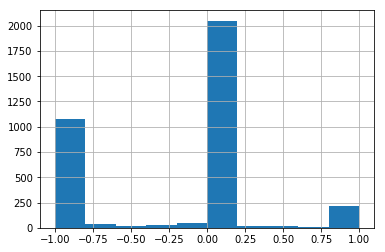

In [6]:
hist_steering = df_records['steering_signal'].hist()

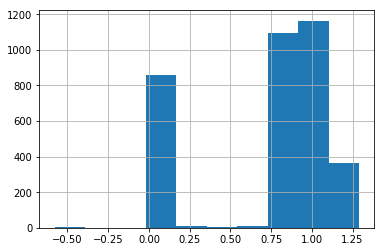

In [7]:
hist_throttle = df_records['throttle_signal'].hist()

In [8]:
# Conversion between categorical and floating point steering
def linear_bin(a):
    a = a + 1
    b = round(a / (2 / 14))
    arr = np.zeros(15)
    arr[int(b)] = 1
    return arr


def linear_unbin(arr):
    if not len(arr) == 15:
        raise ValueError('Illegal array length, must be 15')
    b = np.argmax(arr)
    a = b * (2 / 14) - 1
    return a


def bin_Y(Y):
    d = [ linear_bin(y) for y in Y ]
    return np.array(d)


def unbin_Y(Y):
    d = [ linear_unbin(y) for y in Y ]
    return np.array(d)

test_val = 0.5
print("Value", test_val)
Y_categorical = bin_Y([test_val])
print("Categorical", Y_categorical)
print("Back to value", unbin_Y(Y_categorical))

#print()


Value 0.5
Categorical [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Back to value [0.42857143]


In [10]:
##indices= sel_indices
def get_n_records(df_records, frames, indices):
    #this_frame = np.array[frames[idx] for idx in indices]
    these_frames = [frames[idx] for idx in indices]
    
    frame_array = np.stack([frames[idx] for idx in indices], axis=0)
    #this_steering = df_records[df_records['timestamp'] == idx]['steering_signal']
    these_steering = df_records[df_records['timestamp'].isin(indices)]['steering_signal'].values
    
    these_throttle = df_records[df_records['timestamp'].isin(indices)]['throttle_signal'].values
    
    timestamps = df_records[df_records['timestamp'].isin(indices)]['timestamp'].values
    #this_steering = df_records[idx]
    
    these_ts = [datetime.datetime.fromtimestamp(int(ts)/1000) for ts in timestamps]
    return frame_array,these_steering,these_throttle, these_ts


#frame, steering = get_record(df_records,frames, '1533666134582')

sel_indices = df_records.sample(5)['timestamp'].values
sel_frames, sel_steerings, sel_throttles, sel_ts = get_n_records(df_records, frames, sel_indices)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=30.0 to DejaVu Sans ('/home/batman/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


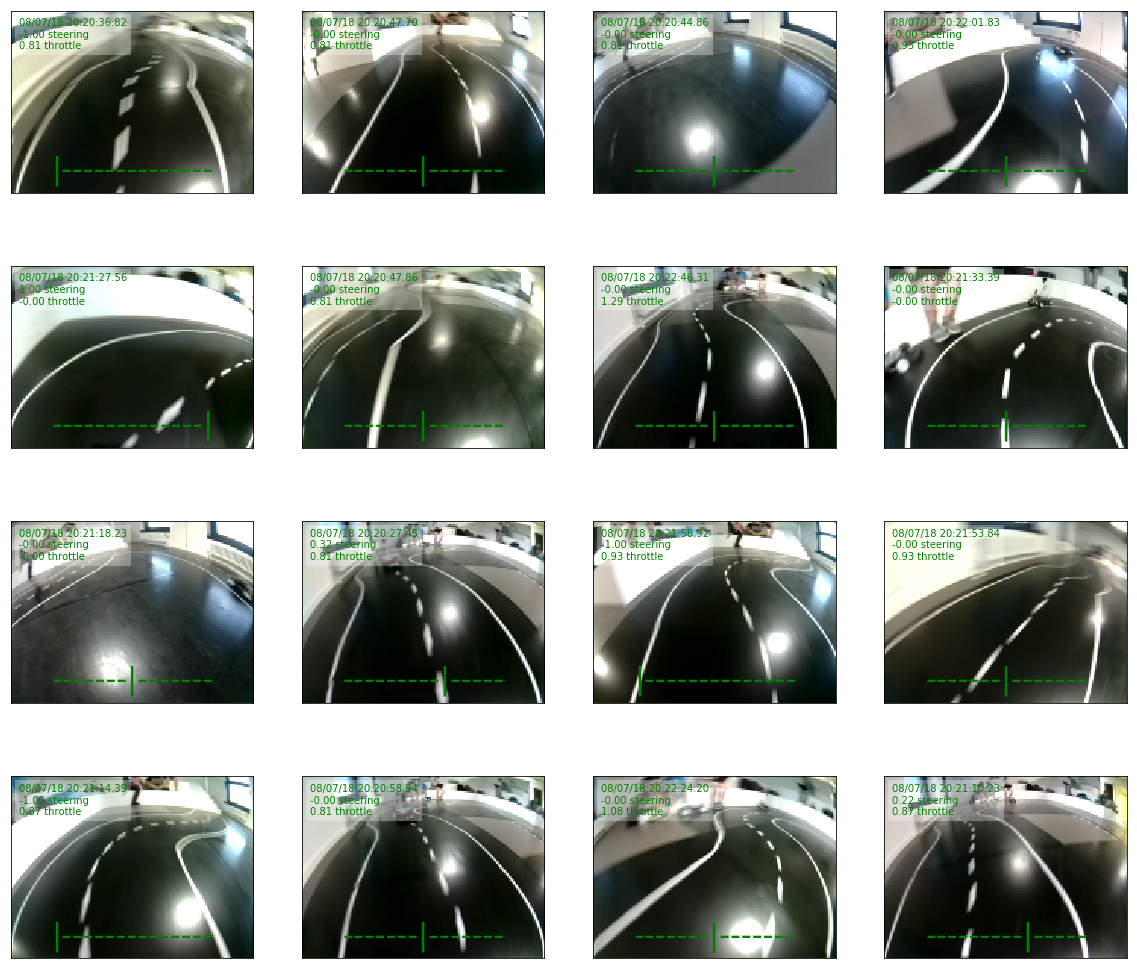

In [11]:
fig=plt.figure(figsize=[20,18],facecolor='white')
ROWS = 4
COLS = 4
NUM_IMAGES = ROWS * COLS
sel_indices = df_records.sample(NUM_IMAGES)['timestamp'].values
sel_frames, sel_steerings, sel_throttles, these_ts = get_n_records(df_records, frames, sel_indices)

for i,record in enumerate(zip(sel_frames, sel_steerings,sel_throttles,these_ts)):
    this_frame, this_steer, this_throttle,sel_ts = record
    
    steer_cat = ''.join(['|' if v else '-' for v in linear_bin(this_steer)])
    timestamp_string = sel_ts.strftime("%D %H:%M:%S.") + "{:.2}".format(str(sel_ts.microsecond))
    
    this_label = "{}\n{:0.2f} steering\n{:0.2f} throttle".format(timestamp_string,this_steer,this_throttle)
    y = fig.add_subplot(ROWS,COLS,i+1)
    y.imshow(this_frame)
    #plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    t = y.text(5,25,this_label,color='green',alpha=1)
    #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
    t.set_bbox(dict(facecolor='white', alpha=0.3,edgecolor='none'))
    y.text(80,105,steer_cat,fontsize=30,horizontalalignment='center',verticalalignment='center',color='green')
    #plt.title()


In [12]:
class MuleDataGenerator(ks.utils.Sequence):
    """Generates data for Keras"""
    def __init__(self, list_IDs, path_frames, path_records, 
                 batch_size=32, dim=None, n_channels=None, n_classes=15, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.path_frames = path_frames
        assert os.path.exists(self.path_frames)
        self.path_records = path_records
        assert os.path.exists(self.path_records)
        logging.debug("** Initialize datagen **".format())
        logging.debug("Frames stored at: {}".format(self.path_frames))
        logging.debug("Records stored at: {}".format(self.path_records))
        logging.debug("{} samples over batch size {} yields {} batches".format(len(list_IDs),
                                                                                   params['batch_size'],
                                                                                   math.ceil(len(list_IDs)/params['batch_size']),))
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    # GET A BATCH!
    def __getitem__(self, index): 
        'Generate one batch of data'
        
        logging.debug("Generating batch {}".format(index))
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data by selecting these IDs
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __get_npy_arrays(self,list_IDs_temp):
        """Open the npz file and load n frames into memory"""
        # This is a pointer to the file
        npz_file=np.load(self.path_frames)
        #for k in list_ID_temp:
        #    npy_records.append(npz_file[k])
        #X_train = np.array(npy_records)
        
        frames_array = np.stack([npz_file[idx] for idx in list_IDs_temp], axis=0)
        logging.debug("Generating {} frames: {}".format(frames_array.shape[0], frames_array.shape))
        
        return frames_array
    
    def __get_records(self,list_IDs_temp):
        
        # Load the saved records
        df_records = pd.read_pickle(self.path_records)
        # Set the index to match
        df_records.index = df_records['timestamp']
        # Subset
        this_batch_steering = df_records.loc[list_IDs_temp]
        
        steering_values = this_batch_steering['steering_signal'].values
        
        #print(steering_values)
        steering_records_array = bin_Y(steering_values)
        
        #df_categorical_steering = df_records['steering_signal']
        #
        
        
        #records_array = df_records[]
        logging.debug("Generating {} records {}:".format(steering_records_array.shape[0],steering_records_array.shape))
        return steering_records_array
        
        #raise
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        #X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        
        X = self.__get_npy_arrays(list_IDs_temp)
        y = self.__get_records(list_IDs_temp)
        
        # Generate data
        #for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            #y[i] = self.labels[ID]
        #    pass

        return X, y

In [13]:
msk = np.random.rand(len(df_records)) < 0.8
partition = dict()
partition['train'] = df_records.index[msk].values
partition['validation'] = df_records.index[~msk].values
#labels = range(15)

In [14]:
params = {'dim': (160,120),
          'batch_size': 32,
          'n_classes': 15,
          'n_channels': 3,
          'shuffle': True,
          'path_frames':os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'camera_numpy.zip'),
          'path_records':os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'df_record.pck'),
         }

training_generator = MuleDataGenerator(partition['train'], **params)
validation_generator = MuleDataGenerator(partition['validation'], **params)
logging.debug("**")
logging.debug("Data Generators: {} samples over batch size {} yields ~{} batches: {} / {} train/val ".format(len(df_records),
                                                                                   params['batch_size'],
                                                                                   math.ceil(len(df_records)/params['batch_size']),
                                                                                   len(training_generator),
                                                                                  len(validation_generator)))



DEBUG:root:** Initialize datagen **
DEBUG:root:Frames stored at: /home/batman/MULE DATA/20180807 201756/camera_numpy.zip
DEBUG:root:Records stored at: /home/batman/MULE DATA/20180807 201756/df_record.pck
DEBUG:root:2768 samples over batch size 32 yields 87 batches
DEBUG:root:** Initialize datagen **
DEBUG:root:Frames stored at: /home/batman/MULE DATA/20180807 201756/camera_numpy.zip
DEBUG:root:Records stored at: /home/batman/MULE DATA/20180807 201756/df_record.pck
DEBUG:root:745 samples over batch size 32 yields 24 batches
DEBUG:root:**
DEBUG:root:Data Generators: 3513 samples over batch size 32 yields ~110 batches: 86 / 23 train/val 


In [16]:
first_batch = validation_generator[0]
last_batch = validation_generator[len(validation_generator)]

DEBUG:root:Generating batch 0
DEBUG:root:Generating 32 frames: (32, 120, 160, 3)
DEBUG:root:Generating 32 records (32, 15):
DEBUG:root:Generating batch 23
DEBUG:root:Generating 9 frames: (9, 120, 160, 3)
DEBUG:root:Generating 9 records (9, 15):


In [18]:
def baseline_steering_model():
    model = ks.models.Sequential()
    model.add(ks.layers.Conv2D(24, (5,5), strides=(2, 2), activation = "relu", input_shape=(120,160,3)))
    model.add(ks.layers.Conv2D(32, (5,5), strides=(2, 2), activation = "relu"))
    model.add(ks.layers.Conv2D(64, (5,5), strides=(2, 2), activation = "relu"))
    model.add(ks.layers.Conv2D(64, (3,3), strides=(2, 2), activation = "relu"))
    model.add(ks.layers.Conv2D(64, (3,3), strides=(1, 1), activation = "relu"))
    model.add(ks.layers.Flatten()) # This is just a reshape!
    model.add(ks.layers.Dense(100,activation="relu"))
    model.add(ks.layers.Dropout(0.1))
    model.add(ks.layers.Dense(50,activation="relu"))
    model.add(ks.layers.Dropout(0.1))
    model.add(ks.layers.Dense(15, activation='softmax', name='angle_out'))
    return model
blmodel = baseline_steering_model()

In [19]:
blmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 78, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 32)        19232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 17, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 8, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 6, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [21]:
blmodel.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[ks.metrics.categorical_accuracy]
               )

In [22]:
with LoggerCritical():
    history = blmodel.fit_generator(generator=training_generator,
                      validation_data=validation_generator,
                      use_multiprocessing=True,
                      workers=6,
                      epochs=3,
                      verbose=1,)

Epoch 1/3
86/86 [==============================] - 22s 257ms/step - loss: 1.2455 - categorical_accuracy: 0.6602 - val_loss: 0.9152 - val_categorical_accuracy: 0.7188
Epoch 2/3
86/86 [==============================] - 24s 277ms/step - loss: 0.9217 - categorical_accuracy: 0.7398 - val_loss: 0.8072 - val_categorical_accuracy: 0.7554
Epoch 3/3
86/86 [==============================] - 26s 298ms/step - loss: 0.8190 - categorical_accuracy: 0.7627 - val_loss: 0.7625 - val_categorical_accuracy: 0.7636


In [65]:
# Get the raw predicted probability vector
def raw_predictions(model,frames):
    frame_array = np.stack([frames[idx] for idx in frames], axis=0)
    y_pred_categorical = model.predict(frame_array)
    #print(y_pred_categorical)
    #y_pred = unbin_Y(y_pred_categorical)
    return pd.DataFrame(y_pred_categorical,index = [idx for idx in frames])

df_ypred_probs = raw_predictions(blmodel,frames)
df_ypred_probs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1533666046324,0.905615,0.000719,0.000167,0.000606,0.000915,0.001458,0.000719,0.088239,0.000427,0.000535,0.000163,0.000122,0.000007,0.000015,0.000294
1533666126543,0.006137,0.002810,0.001473,0.006032,0.002068,0.001174,0.006762,0.846662,0.006952,0.001591,0.001473,0.000833,0.006621,0.006604,0.102807
1533666152576,0.928007,0.000765,0.000353,0.000415,0.001986,0.002461,0.000479,0.062936,0.000565,0.000642,0.000186,0.000278,0.000017,0.000090,0.000819
1533666027207,0.000920,0.000041,0.000051,0.000454,0.000145,0.000018,0.000300,0.979551,0.000222,0.000018,0.000135,0.000024,0.000312,0.000151,0.017657
1533666046199,0.860534,0.001561,0.000418,0.003099,0.001864,0.001364,0.002822,0.124093,0.001072,0.000979,0.000658,0.000155,0.000025,0.000036,0.001320


In [77]:
# Get the raw predicted argmax vector
def argmax_predictions(raw_probs):
    # Get the argmax of each row, as a 1D array
    argmaxxes = np.argmax(raw_probs.values,axis=1)
    # Initialize the output array
    arr = np.zeros((len(argmaxxes),15))
    
    # Iterate and set the max probability to 1, else 0
    for i,argmax in enumerate(argmaxxes):
        arr[i][argmax] = 1
    #frame_array = np.stack([frames[idx] for idx in frames], axis=0)
    #y_pred_categorical = model.predict(frame_array)
    #print(y_pred_categorical)
    #y_pred = unbin_Y(y_pred_categorical)
    return pd.DataFrame(arr,index = raw_probs.index)

df_ypred_onehot = argmax_predictions(df_ypred_probs)
df_ypred_onehot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1533666046324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666126543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666152576,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666027207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666046199,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Get the floating point steering value from the probability
def categorical_predictions(y_pred_raw):
    y_pred_cats = unbin_Y(y_pred_raw.values)
    #pd.DataFrame(y_pred_cats,index = [idx for idx in frames])
    return pd.DataFrame({"steering_pred":y_pred_cats},index = [idx for idx in frames])   
y_pred_floats = categorical_predictions(y_pred_raw)
y_pred_floats.head()

,steering_pred
1533666046324,-1.0
1533666126543,0.0
1533666152576,-1.0
1533666027207,0.0
1533666046199,-1.0


In [37]:
#df_final = df_records.join(y_pred_all)
#df_final.head()

In [38]:
#res = df_final.loc[:,['steering_signal','steering_pred']]

In [359]:
# def cross_entropy(targets,predictions):
#     N = predictions.shape[0]
#     ce = -np.sum(targets*np.log(predictions))/N
#     return ce

In [42]:
#df_small = df_.head(40)
#df_small = df_final

In [43]:
# Mean Squared Error from y_pred_floats
targets = df_records['steering_signal'].values
predictions = y_pred_floats['steering_pred'].values
N = predictions.shape[0]
sums_cumul = list()
for y_actual, y_pred in zip(targets,predictions):
    part_sum = (y_actual-y_pred)**2
    #print(y_actual, " - ",y_pred, "=",part_sum)
    sums_cumul.append(part_sum)
print("Total sum:",sum(sums_cumul))
print("MSE:",sum(sums_cumul)/N)

Total sum: 2103.7922666037375
MSE: 0.5988591706813942


In [383]:
# Categorical accuracy from the 
# Sum the correctly matching categories
targets = df_records['steering_signal'].values
predictions = df_small['steering_pred'].values
N = predictions.shape[0]
sums_cumul = list()
for y_actual, y_pred in zip(targets,predictions):
    y_actual_cats = linear_bin(y_actual)
    y_pred_cats = linear_bin(y_pred)
    #print(y_actual_cats)
    #print(y_pred_cats)
    sums_cumul.append(all(y_actual_cats == y_pred_cats))
    
    #part_sum = (y_actual-y_pred)**2
    #print(y_actual, " - ",y_pred, "=",part_sum)
    #sums_cumul.append(part_sum)
print("Total sum:",sum(sums_cumul))
print("Categorical Accuracy:",sum(sums_cumul)/N)

Total sum: 3177
Categorical Accuracy: 0.9043552519214346


In [386]:
sess = tf.InteractiveSession()
with sess.as_default():
    overall_accuracy = ks.metrics.categorical_accuracy(bin_Y(res['steering_signal']), bin_Y(res['steering_pred'])).eval()
    overall_categorical_crossentropy = ks.losses.categorical_crossentropy(ks.backend.constant(bin_Y(res['steering_signal'])), 
                                                                          ks.backend.constant(bin_Y(res['steering_pred']))).eval()
print(sum(overall_accuracy)/len(res['steering_signal']))
print(sum(overall_categorical_crossentropy))


/home/batman/anaconda3/envs/muleai/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0.9043552519214346
5415.68043243885


In [ ]:
def get_n_predictions(model,frames,indices):
    these_frames = [frames[idx] for idx in indices]
    frame_array = np.stack([frames[idx] for idx in indices], axis=0)
    y_pred_categorical = model.predict(frame_array)
    #print(y_pred_categorical)
    y_pred = unbin_Y(y_pred_categorical)
    return y_pred


In [256]:
history_dict = history.__dict__
#history_dict

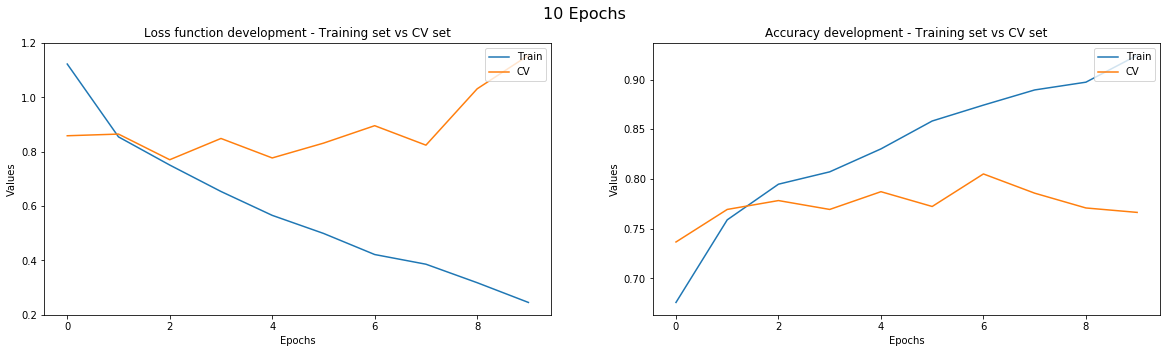

In [257]:
#model_title = "10 Epochs"
def plot_hist(history_dict, accuracy_name):
    #fig = plt.figure(figsize=(5,4))
    #fig=plt.figure(figsize=(20, 10),facecolor='white')

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='white')
    bgcolor = '0.15'
    bgcolor = 'white'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor=bgcolor)
    
    ax1.plot(history_dict['epoch'],  history_dict['history']['loss'],label="Train")
    ax1.plot(history_dict['epoch'],  history_dict['history']['val_loss'],label="CV")
    ax1.set_title("Loss function development - Training set vs CV set")
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Values')
    
    ax2.plot(history_dict['epoch'],  history_dict['history'][accuracy_name],label="Train")
    ax2.plot(history_dict['epoch'],  history_dict['history']['val_'+accuracy_name],label="CV")
    ax2.set_title("Accuracy development - Training set vs CV set")
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Values')
    
    plt.suptitle(model_title, fontsize=16)
    
    plt.show()

plot_hist(history_dict,'categorical_accuracy')

In [258]:
df_records.head()
#df_records.columns
#model.predict()

,led_flags,mode,steering_signal,throttle_signal,timestamp
timestamp,,,,,
1533666054613,"[False, False, True, False]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,0.81,1533666054613
1533666054946,"[True, False, False, False]","{'recording': True, 'steering': 'human', 'thro...",-0.134007,0.81,1533666054946
1533666128877,"[False, False, False, False]","{'recording': True, 'steering': 'human', 'thro...",-1.000000,0.93,1533666128877
1533666100553,"[False, False, True, False]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,0.93,1533666100553
1533666147826,"[False, False, False, True]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,1.29,1533666147826


In [ ]:
#df_records

In [278]:

#for p in get_n_predictions(blmodel,frames,sel_indices):
#    print(p)   

In [279]:
#get_n_predictions(blmodel,frames,sel_indices)

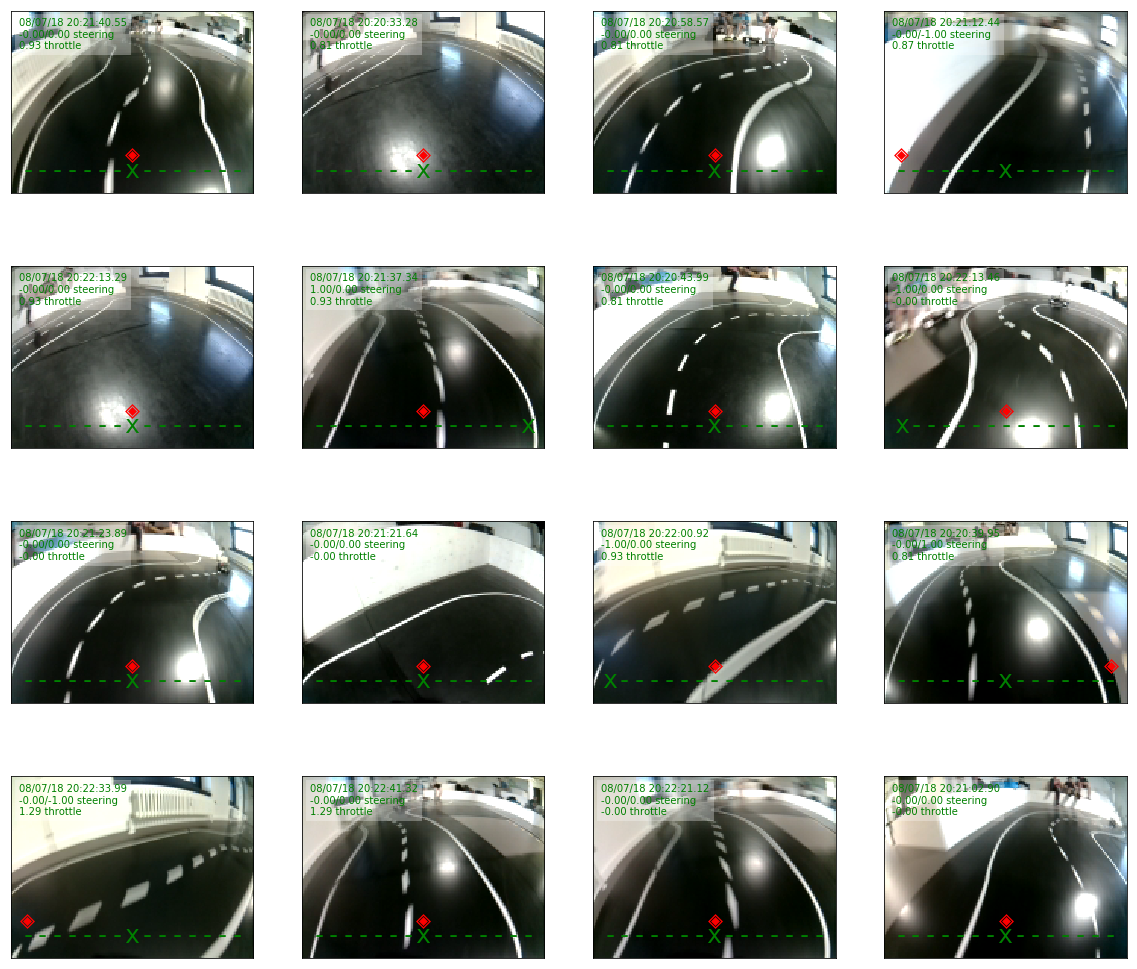

In [284]:
fig=plt.figure(figsize=[20,18],facecolor='white')
ROWS = 4
COLS = 4
NUM_IMAGES = ROWS * COLS
sel_indices = df_records.sample(NUM_IMAGES)['timestamp'].values
sel_frames, sel_steerings, sel_throttles, these_ts = get_n_records(df_records, frames, sel_indices)

sel_predictions = get_n_predictions(blmodel,frames,sel_indices)

font_steering = {'family': 'monospace',
        #'color':  'darkred',
        'weight': 'normal',
        'size': 25,
        }

for i,record in enumerate(zip(sel_frames, sel_steerings,sel_predictions,sel_throttles,these_ts)):
    this_frame, this_steer, this_pred, this_throttle,sel_ts = record
    
    steer_actual = ''.join(['x' if v else '-' for v in linear_bin(this_steer)])
    steer_pred = ''.join(['◈' if v else ' ' for v in linear_bin(this_pred)])
    timestamp_string = sel_ts.strftime("%D %H:%M:%S.") + "{:.2}".format(str(sel_ts.microsecond))
    
    this_label = "{}\n{:0.2f}/{:0.2f} steering \n{:0.2f} throttle".format(timestamp_string,this_steer,this_pred,this_throttle)
    y = fig.add_subplot(ROWS,COLS,i+1)
    y.imshow(this_frame)
    #plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    t = y.text(5,25,this_label,color='green',alpha=1)
    #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
    t.set_bbox(dict(facecolor='white', alpha=0.3,edgecolor='none'))
    
    y.text(80,105,steer_actual,fontdict=font_steering,horizontalalignment='center',verticalalignment='center',color='green')
    y.text(80,95,steer_pred,fontdict=font_steering,horizontalalignment='center',verticalalignment='center',color='red')
    
    #plt.title()
